# Adaptive Large Neighbourhood Search (ALNS) for VRPTW  

- Define destroy / repair operators for ALNS.
- Run a basic ALNS loop with simulated annealing style acceptance.
- Inspect operator usage and adaptation over time.


## 1. Problem definition: VRPTW (Solomon-style)

We are given:

- A depot `0` with:
  - coordinates `(x_0, y_0)`
  - earliest departure time `e_0` and latest return time `l_0`
- A fleet of `K` identical vehicles with capacity `Q`.
- A set of customers `i = 1, …, n`, each with:
  - demand `d_i` (units to deliver / pick up)
  - service time `s_i`
  - coordinates `(x_i, y_i)`
  - time window `[e_i, l_i]`:
    the vehicle **may not start servicing customer _i_ before `e_i`,
    and must *start* service no later than `l_i`.**

Each vehicle builds one route that:
1. starts at the depot,
2. visits a subset of customers,
3. returns to the depot.

### Feasibility constraints
For every route:
- **Capacity**: sum of demands ≤ `Q`.
- **Time feasibility**:
  - We simulate driving + waiting + service times along the route.
  - Arriving early is allowed, but you **must wait** until the window opens.
  - Arriving after `l_i` is infeasible.

### Objective
Minimise total driven distance (or travel time — we assume symmetric Euclidean distance here).

We'll work with *classical Solomon benchmark instances*
(see M. Solomon, 1987), but we also include a toy generator so this runs standalone.


## 2. Data model

We'll define small dataclasses so that code stays readable.

We keep:
- problem-level info (`Q`, depot)
- list of customers
- a distance matrix for fast lookup

We also include a tiny **toy instance generator** so the notebook runs even if
the Solomon `.txt` files are not available on your machine.


In [1]:
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import math
import random

@dataclass
class Customer:
    idx: int          # 0 is depot
    x: float
    y: float
    demand: float
    ready_time: float   # earliest start of service e_i
    due_time: float     # latest start of service l_i
    service_time: float # s_i

@dataclass
class VRPTWInstance:
    Q: float                         # vehicle capacity
    customers: List[Customer]        # 0 is depot / 1..n are customers
    dist: List[List[float]]          # distance matrix (symmetric here)

    def travel_time(self, i: int, j: int) -> float:
        # assume time == distance
        return self.dist[i][j]

def euclidean(a: Customer, b: Customer) -> float:
    return math.hypot(a.x - b.x, a.y - b.y)

def build_distance_matrix(customers: List[Customer]) -> List[List[float]]:
    n = len(customers)
    D = [[0.0]*n for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            d = euclidean(customers[i], customers[j])
            D[i][j] = D[j][i] = d
    return D


### 2.1 Toy instance generator

If you don't have Solomon instances locally, run this cell and you'll get
a tiny VRPTW with ~15 customers clustered near the depot.

The time windows are *tight-ish* to make the problem interesting, but still solvable
with a few short routes.


In [2]:
def make_toy_instance(n_customers: int = 15,
                        seed: int = 42,
                        Q: float = 200.0) -> VRPTWInstance:
    rnd = random.Random(seed)

    # Depot at (50, 50), generous time window
    depot = Customer(
        idx=0,
        x=50.0, y=50.0,
        demand=0.0,
        ready_time=0.0,
        due_time=200.0,
        service_time=0.0,
    )

    customers = [depot]
    for i in range(1, n_customers+1):
        # cluster around depot in radius ~20
        x = 50 + rnd.uniform(-20, 20)
        y = 50 + rnd.uniform(-20, 20)

        demand = rnd.uniform(5, 30)
        service_time = rnd.uniform(5, 15)

        # create a feasible-ish time window around ~distance * 1.5
        dist_from_depot = math.hypot(x-50, y-50)
        earliest = dist_from_depot * 1.5
        latest   = earliest + rnd.uniform(20, 60)

        cust = Customer(
            idx=i,
            x=x, y=y,
            demand=demand,
            ready_time=earliest,
            due_time=latest,
            service_time=service_time,
        )
        customers.append(cust)

    D = build_distance_matrix(customers)
    return VRPTWInstance(Q=Q, customers=customers, dist=D)


toy = make_toy_instance()
toy, len(toy.customers)


(VRPTWInstance(Q=200.0, customers=[Customer(idx=0, x=50.0, y=50.0, demand=0.0, ready_time=0.0, due_time=200.0, service_time=0.0), Customer(idx=1, x=55.57707193831535, y=31.00043020890668, demand=11.875732959227982, ready_time=29.701794781064724, due_time=79.16064334762522, service_time=7.232107381488228), Customer(idx=2, x=57.06797949691645, y=65.68718270819382, demand=7.173470815735404, ready_time=25.808895362848144, due_time=47.00078414037095, service_time=9.219218196852704), Customer(idx=3, x=38.745518992144135, y=50.2142115241345, demand=5.663399242096591, ready_time=16.884779122032835, due_time=62.88015663321376, service_time=6.988376506866485), Customer(idx=4, x=51.797659224128665, y=38.817624881627864, demand=19.731642096897716, ready_time=16.98892159442991, due_time=37.248871981552355, service_time=13.094304566778266), Customer(idx=5, x=62.23277007331232, y=57.92557579952907, demand=13.506262912949797, ready_time=21.863775627653247, due_time=80.15229851592449, service_time=6.55

## 3. Feasibility and cost helpers

We'll represent a solution as a *list of routes*, where each route is a list of
customer indices **including depot at start and end**, e.g.:

```python
route = [0, 7, 3, 12, 0]
solution = [
    [0, 7, 3, 12, 0],
    [0, 5, 11, 4, 0],
    ...
]
```

We'll implement:
1. Capacity feasibility for a route.
2. Time window feasibility for a route.
3. Total distance for a full solution.
4. A global feasibility check that everyone is visited once.


In [3]:
def route_capacity_ok(inst: VRPTWInstance, route: List[int]) -> bool:
    load = 0.0
    for idx in route:
        if idx == 0:
            continue
        load += inst.customers[idx].demand
        if load > inst.Q + 1e-9:
            return False
    return True

def route_time_feasible(inst: VRPTWInstance, route: List[int]) -> bool:
    t = 0.0  # time clock
    for a, b in zip(route, route[1:]):
        # drive
        t += inst.travel_time(a, b)
        cust_b = inst.customers[b]

        # wait if early
        if t < cust_b.ready_time:
            t = cust_b.ready_time

        # if late -> infeasible
        if t > cust_b.due_time + 1e-9:
            return False

        # serve
        t += cust_b.service_time
    return True

def total_distance(inst: VRPTWInstance, solution: List[List[int]]) -> float:
    dist = 0.0
    for route in solution:
        for a, b in zip(route, route[1:]):
            dist += inst.dist[a][b]
    return dist

def solution_feasible(inst: VRPTWInstance, solution: List[List[int]]) -> bool:
    seen = set()
    for route in solution:
        # must start & end at depot
        if route[0] != 0 or route[-1] != 0:
            return False
        # capacity
        if not route_capacity_ok(inst, route):
            return False
        # time windows
        if not route_time_feasible(inst, route):
            return False
        # unique visit
        for c in route[1:-1]:
            if c in seen:
                return False
            seen.add(c)

    # all non-depot customers covered exactly once
    all_customers = set(range(1, len(inst.customers)))
    return seen == all_customers


## 4. Greedy insertion heuristic (initial solution)

We'll build routes one by one:

1. Start a new empty route `[0, 0]` (depot → depot).
2. While there is an uncovered customer that *can still be inserted feasibly*,
   choose the "cheapest insertion" (minimal extra distance) that keeps
   capacity and time windows feasible.
3. When no insertion is possible, **start a new vehicle** and repeat.

This is not state of the art, but it's a solid warm start for ALNS.

If the heuristic fails to insert everyone in that route, we fall back to a
single-customer route `[0, i, 0]` for that hard customer.


In [4]:
def try_insert_customer(inst: VRPTWInstance,
                         route: List[int],
                         cust_idx: int) -> Optional[Tuple[float, List[int]]]:
    """
    Try to insert `cust_idx` somewhere between route[k] -> route[k+1].
    Return (extra_cost, new_route) if feasible, else None.
    """
    best = None
    for k in range(len(route)-1):
        cand = route[:k+1] + [cust_idx] + route[k+1:]
        # capacity/time check
        if not route_capacity_ok(inst, cand):
            continue
        if not route_time_feasible(inst, cand):
            continue
        # delta distance
        a, b = route[k], route[k+1]
        old = inst.dist[a][b]
        new = inst.dist[a][cust_idx] + inst.dist[cust_idx][b]
        extra = new - old
        if best is None or extra < best[0]:
            best = (extra, cand)
    return best

def greedy_initial_solution(inst: VRPTWInstance,
                            rng: random.Random = random.Random(0)) -> List[List[int]]:
    unrouted = set(range(1, len(inst.customers)))
    solution: List[List[int]] = []

    while unrouted:
        # start new vehicle
        route = [0,0]

        improved = True
        while improved and unrouted:
            improved = False
            # evaluate cheapest insertion for each remaining customer
            best_move = None
            for cidx in list(unrouted):
                res = try_insert_customer(inst, route, cidx)
                if res is None:
                    continue
                extra, new_route = res
                if (best_move is None) or (extra < best_move[0]):
                    best_move = (extra, cidx, new_route)
            if best_move is not None:
                _, cidx, new_route = best_move
                route = new_route
                unrouted.remove(cidx)
                improved = True

        # fallback: if route is still just depot->depot but we still have unrouted,
        # force one hard customer into its own route [0, i, 0]
        if route == [0,0] and unrouted:
            cidx = unrouted.pop()
            route = [0, cidx, 0]
            # sanity check
            if (not route_capacity_ok(inst, route)) or (not route_time_feasible(inst, route)):
                raise RuntimeError(f"Even single-customer route infeasible for {cidx}?")

        solution.append(route)

    return solution


# smoke test on toy instance
rnd = random.Random(123)
sol0 = greedy_initial_solution(toy, rnd)

print("Initial solution routes:", sol0)
print("Feasible?", solution_feasible(toy, sol0))
print("Distance:", total_distance(toy, sol0))


Initial solution routes: [[0, 11, 3, 15, 0], [0, 12, 4, 14, 1, 0], [0, 7, 2, 8, 0], [0, 13, 5, 0], [0, 10, 6, 0], [0, 9, 0]]
Feasible? True
Distance: 286.67368378072393


## 5. Destroy & Repair operators

ALNS iterates:
1. **Destroy** current solution: remove a subset of customers from their routes.
2. **Repair**: reinsert those customers (e.g. using our greedy insertion).

We keep a pool of destroy operators:
- `random_removal`: remove random customers.
- `shaw_removal`: remove "related" customers (close in distance).

We'll later assign probabilities to these operators and adapt them.


In [5]:
def flatten_routes(solution: List[List[int]]) -> List[int]:
    seq = []
    for r in solution:
        seq.extend(r[1:-1])  # skip depot endpoints
    return seq

def remove_customers(solution: List[List[int]], to_remove: List[int]) -> List[List[int]]:
    new_sol = []
    for r in solution:
        nr = [c for c in r if (c not in to_remove) or (c==0)]
        # ensure depot endpoints remain [0,...,0]
        if nr[0] != 0:
            nr = [0] + nr
        if nr[-1] != 0:
            nr = nr + [0]
        # collapse [0,0] if empty
        if len(nr) < 3:
            nr = [0,0]
        new_sol.append(nr)
    return new_sol

def random_removal(inst: VRPTWInstance,
                   solution: List[List[int]],
                   rng: random.Random,
                   p: float = 0.2):
    all_customers = flatten_routes(solution)
    if not all_customers:
        return solution, []
    k = max(1, int(len(all_customers)*p))
    picked = rng.sample(all_customers, k)
    new_sol = remove_customers(solution, picked)
    return new_sol, picked

def shaw_removal(inst: VRPTWInstance,
                 solution: List[List[int]],
                 rng: random.Random,
                 p: float = 0.2):
    # pick seed
    all_customers = flatten_routes(solution)
    if not all_customers:
        return solution, []
    seed = rng.choice(all_customers)

    def relatedness(i,j):
        # here: Euclidean distance only (time-window closeness could be added)
        return inst.dist[i][j]

    rem_list = [seed]
    cand_pool = set(all_customers) - {seed}
    target_k = max(1, int(len(all_customers)*p))
    while len(rem_list) < target_k and cand_pool:
        # pick the most related (closest) customer to any already selected
        best_j = None
        best_score = None
        for j in list(cand_pool):
            score = min(relatedness(i,j) for i in rem_list)
            if best_score is None or score < best_score:
                best_score = score
                best_j = j
        rem_list.append(best_j)
        cand_pool.remove(best_j)

    new_sol = remove_customers(solution, rem_list)
    return new_sol, rem_list

def repair_greedy(inst: VRPTWInstance,
                  partial_solution: List[List[int]],
                  missing_customers: List[int],
                  rng: random.Random) -> List[List[int]]:
    sol = [r[:] for r in partial_solution]
    unrouted = list(missing_customers)
    rng.shuffle(unrouted)
    for cidx in unrouted:
        # best insertion across *all* current routes
        best_overall = None
        best_r_id = None

        for ridx, route in enumerate(sol):
            res = try_insert_customer(inst, route, cidx)
            if res is not None:
                extra, new_route = res
                if (best_overall is None) or (extra < best_overall[0]):
                    best_overall = (extra, new_route)
                    best_r_id = ridx

        if best_overall is None:
            # open new vehicle
            new_route = [0, cidx, 0]
            sol.append(new_route)
        else:
            _, new_route = best_overall
            sol[best_r_id] = new_route

    return sol


## 6. ALNS main loop (with adaptive operator probabilities)

We'll now implement the ALNS loop with:

- **Metropolis acceptance** (Simulated Annealing style).
- **Operator logging**.
- **Adaptive probabilities** for destroy operators.

### Operator adaptation logic (classical ALNS style, simplified)

We maintain, for each destroy operator:
- a weight (starts at 1.0),
- a running score (sum of rewards this segment),
- a usage count this segment.

At each iteration we:
1. pick an operator according to its normalised weights;
2. apply destroy+repair;
3. score the result with a reward:
   - `5` if it produced a new global best,
   - `2` if it improved over the current solution,
   - `0.5` if it's accepted but worse,
   - `0` if it's rejected / infeasible;
4. add that reward to that operator's score.

After each `segment_length` iterations, we update the weights:
```text
weight_i = α * weight_i + (1-α) * (score_i / max(usage_i,1))
```
then re-normalise weights to get new probabilities,
and reset the segment scores and usage counters.

We also log:
- which operator fired,
- old vs new cost,
- whether it was accepted,
- reward,
- current probabilities.


In [6]:
import math

def accept_metropolis(old_cost: float, new_cost: float, T: float, rng: random.Random) -> bool:
    if new_cost <= old_cost:
        return True
    # worse -> accept with exp(-(delta)/T)
    delta = new_cost - old_cost
    prob = math.exp(-delta / max(T,1e-9))
    return (rng.random() < prob)

def weighted_choice(rng: random.Random, probs: List[float]) -> int:
    # pick index i with probability probs[i]
    s = sum(probs)
    if s <= 0:
        # fallback: uniform
        u = rng.randrange(len(probs))
        return u
    r = rng.random() * s
    acc = 0.0
    for i,p in enumerate(probs):
        acc += p
        if r <= acc:
            return i
    return len(probs)-1

def alns(inst: VRPTWInstance,
         iters: int = 200,
         p_remove: float = 0.2,
         T0: float = 10.0,
         cooling: float = 0.995,
         seed: int = 0,
         alpha: float = 0.8,          # smoothing for weight update
         segment_length: int = 20):
    rng = random.Random(seed)

    # --- operator pool ---
    destroy_ops = [
        ("random", random_removal),
        ("shaw",   shaw_removal),
    ]
    n_ops = len(destroy_ops)

    # initial equal weights / probs
    weights = [1.0 for _ in range(n_ops)]
    probs   = [1.0/n_ops for _ in range(n_ops)]

    # per-segment accumulators
    seg_score = [0.0 for _ in range(n_ops)]
    seg_used  = [0   for _ in range(n_ops)]

    # --- init solution ---
    curr = greedy_initial_solution(inst, rng)
    curr_cost = total_distance(inst, curr)
    best = [r[:] for r in curr]
    best_cost = curr_cost

    hist_best_cost = [best_cost]
    T = T0

    # iteration log (list of dicts)
    iter_log = []

    for it in range(iters):
        # choose destroy operator according to probs
        op_id = weighted_choice(rng, probs)
        op_name, op_fun = destroy_ops[op_id]

        # destroy + repair
        partial, removed = op_fun(inst, curr, rng, p=p_remove)
        cand = repair_greedy(inst, partial, removed, rng)

        accepted = False
        reward   = 0.0
        note     = ""

        if solution_feasible(inst, cand):
            cand_cost = total_distance(inst, cand)

            if accept_metropolis(curr_cost, cand_cost, T, rng):
                accepted = True

                # classify quality for reward
                if cand_cost < best_cost - 1e-9:
                    reward = 5.0
                    note = "new_global_best"
                elif cand_cost < curr_cost - 1e-9:
                    reward = 2.0
                    note = "improved_curr"
                else:
                    reward = 0.5
                    note = "accepted_worse"

                # update current solution
                curr, curr_cost = cand, cand_cost

                # maybe update best
                if cand_cost < best_cost - 1e-9:
                    best, best_cost = [r[:] for r in cand], cand_cost
            else:
                reward = 0.0
                note = "rejected"
        else:
            # infeasible
            reward = 0.0
            note = "infeasible"

        # bookkeeping for operator learning
        seg_score[op_id] += reward
        seg_used[op_id]  += 1

        # log iteration
        iter_log.append({
            "iter": it,
            "T": T,
            "op_id": op_id,
            "op_name": op_name,
            "accepted": accepted,
            "reward": reward,
            "note": note,
            "curr_cost": curr_cost,
            "best_cost": best_cost,
            "probs_snapshot": probs[:],   # copy
        })

        # cooling
        hist_best_cost.append(best_cost)
        T *= cooling

        # segment update?
        if (it+1) % segment_length == 0:
            for j in range(n_ops):
                if seg_used[j] > 0:
                    avg_score = seg_score[j] / seg_used[j]
                else:
                    avg_score = 0.0
                # exponential smoothing of weights
                weights[j] = alpha * weights[j] + (1.0-alpha) * avg_score

            # renormalise probs
            s = sum(weights)
            if s <= 0:
                probs = [1.0/n_ops for _ in range(n_ops)]
            else:
                probs = [w/s for w in weights]

            # reset segment accumulators
            seg_score = [0.0 for _ in range(n_ops)]
            seg_used  = [0   for _ in range(n_ops)]

    # return all diagnostics
    return {
        "best_solution": best,
        "best_cost": best_cost,
        "history": hist_best_cost,
        "iter_log": iter_log,
        "final_probs": probs,
        "final_weights": weights,
    }


# run demo ALNS on the toy instance
run = alns(toy, iters=200, seed=123)
print("Feasible?", solution_feasible(toy, run["best_solution"]))
print("Best cost:", run["best_cost"])
print("Final operator probs:", run["final_probs"][:])
print("First 5 log rows:")
for row in run["iter_log"][:5]:
    print(row)
print("... total log rows:", len(run["iter_log"]))


Feasible? True
Best cost: 231.73534981667387
Final operator probs: [0.5615415251751936, 0.4384584748248063]
First 5 log rows:
{'iter': 0, 'T': 10.0, 'op_id': 0, 'op_name': 'random', 'accepted': True, 'reward': 5.0, 'note': 'new_global_best', 'curr_cost': 275.1341063822762, 'best_cost': 275.1341063822762, 'probs_snapshot': [0.5, 0.5]}
{'iter': 1, 'T': 9.95, 'op_id': 1, 'op_name': 'shaw', 'accepted': True, 'reward': 5.0, 'note': 'new_global_best', 'curr_cost': 270.41673791915207, 'best_cost': 270.41673791915207, 'probs_snapshot': [0.5, 0.5]}
{'iter': 2, 'T': 9.90025, 'op_id': 1, 'op_name': 'shaw', 'accepted': True, 'reward': 5.0, 'note': 'new_global_best', 'curr_cost': 257.1184548301506, 'best_cost': 257.1184548301506, 'probs_snapshot': [0.5, 0.5]}
{'iter': 3, 'T': 9.85074875, 'op_id': 0, 'op_name': 'random', 'accepted': True, 'reward': 0.5, 'note': 'accepted_worse', 'curr_cost': 257.1184548301506, 'best_cost': 257.1184548301506, 'probs_snapshot': [0.5, 0.5]}
{'iter': 4, 'T': 9.801495006

## 7. Visualisation helpers

Two simple plots (matplotlib):
1. Objective value over iterations.
2. Final routed tours in the plane.

Note: In some environments you may have to `%pip install matplotlib`
if it's not already available.


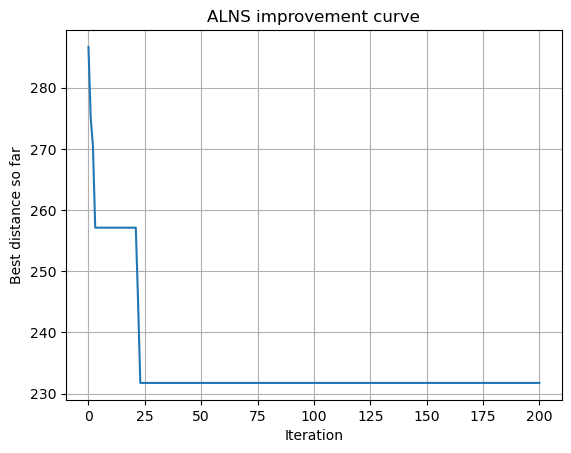

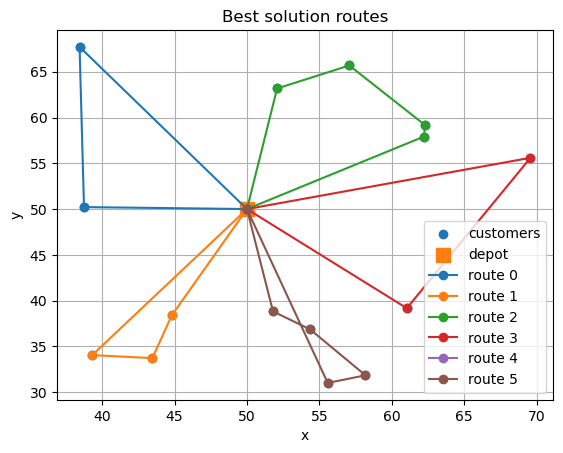

In [7]:
import matplotlib.pyplot as plt

def plot_objective_history(history):
    plt.figure()
    plt.plot(history)
    plt.xlabel("Iteration")
    plt.ylabel("Best distance so far")
    plt.title("ALNS improvement curve")
    plt.grid(True)
    plt.show()

def plot_solution(inst: VRPTWInstance, solution: List[List[int]]):
    plt.figure()
    # plot customers
    xs = [c.x for c in inst.customers]
    ys = [c.y for c in inst.customers]
    plt.scatter(xs, ys, marker='o', label="customers")
    plt.scatter([inst.customers[0].x],[inst.customers[0].y],marker='s',s=100,label='depot')

    # plot each route with matplotlib's color cycle
    for ridx, route in enumerate(solution):
        pts = [inst.customers[i] for i in route]
        rx = [p.x for p in pts]
        ry = [p.y for p in pts]
        plt.plot(rx, ry, marker='o', label=f"route {ridx}")

    plt.title("Best solution routes")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example visualisation for the demo run above
plot_objective_history(run["history"])
plot_solution(toy, run["best_solution"])


## 8. Solomon benchmark loader and exact MILP (PuLP)

In this section we add two extra capabilities:

1. **Parsing Solomon VRPTW instances** from a `.txt` file.  
   Classic Solomon format (1987) looks like this (C1, R1, RC1 classes, etc.):  
   - Early lines include headers with number of vehicles and capacity.  
   - Then for each node (0 is depot) we have columns:  
     `ID  X  Y  DEMAND  READY  DUE  SERVICE`.

   We'll parse that into our `VRPTWInstance`:
   - depot is index `0`
   - capacity `Q` comes from the file
   - we ignore the "max route duration" field for now, to keep the model compact.

2. **Exact MILP using PuLP** with a mainstream MIP solver  
   (we try `gurobi` by default, but you can also ask for `"cplex"`, `"glpk"`, or fallback `"cbc"`).

   The MILP is a standard multi-vehicle VRPTW formulation:
   - Binary `x[i,j]` says "some vehicle drives directly from i to j".
   - `t[i]` is the service start time at node i.
   - `load[i]` is the vehicle load after visiting i.
   - We limit total departures from the depot to at most `K` vehicles.
   - Time continuity + capacity continuity act as MTZ-style subtour breakers.

   After solving, we compare:
   - ALNS best distance
   - MILP objective distance
   - relative gap


### 8.1 Parser for Solomon instances

This parser expects lines with 7 numeric columns:
`ID, X, Y, DEMAND, READY, DUE, SERVICE`

We also try to infer:
- `K` (fleet size) and `Q` (capacity) from the header part of the file.

Returned:
- `inst` : VRPTWInstance
- `K`    : suggested fleet size
- `Q`    : capacity (should match `inst.Q`)


In [8]:
from pathlib import Path

def load_solomon(path: str | Path):
    """
    Minimal Solomon parser.
    Assumes columns (after header block):
    ID  X  Y  DEMAND  READY  DUE  SERVICE

    Returns (inst: VRPTWInstance, K, Q)
    where K is the suggested fleet size from header.
    """
    path = Path(path)
    raw = path.read_text().splitlines()

    # strip empties
    lines = [ln.strip() for ln in raw if ln.strip()]

    # Heuristic parse for K and Q:
    K = None
    Q = None
    for ln in lines:
        toks = ln.split()
        # attempt to parse first two tokens as ints/floats
        if len(toks) >= 2:
            try:
                k_try = int(float(toks[0]))
                q_try = float(toks[1])
            except Exception:
                continue
            # crude heuristic: positive numbers, capacity not tiny
            if k_try > 0 and q_try > 0:
                if K is None:
                    K = k_try
                    Q = q_try

    # Parse the node rows (7 numeric tokens)
    rows = []
    for ln in lines:
        toks = ln.split()
        if len(toks) >= 7:
            try:
                nid   = int(float(toks[0]))
                x     = float(toks[1])
                y     = float(toks[2])
                dem   = float(toks[3])
                ready = float(toks[4])
                due   = float(toks[5])
                serv  = float(toks[6])
                rows.append((nid,x,y,dem,ready,due,serv))
            except Exception:
                pass

    rows.sort(key=lambda r: r[0])

    customers = []
    for (nid,x,y,dem,ready,due,serv) in rows:
        customers.append(Customer(
            idx=nid,
            x=x, y=y,
            demand=dem,
            ready_time=ready,
            due_time=due,
            service_time=serv,
        ))

    if not customers:
        raise ValueError("Could not parse any customers from Solomon file.")

    D = build_distance_matrix(customers)
    inst = VRPTWInstance(Q=Q, customers=customers, dist=D)
    return inst, K, Q


### 8.2 MILP model for VRPTW (multi-vehicle) in PuLP

We'll build a compact MILP (`solve_vrptw_exact`) with:
- Binary arc usage `x[i,j]`
- Service start time `t[i]`
- Remaining load `load[i]`

**Variables**
- `x[i,j] ∈ {0,1}` for all `i != j`
- `t[i] ≥ 0`
- `load[i] ≥ 0`

**Objective**
\(\min \sum_{i \ne j} c_{ij} x_{ij}\)

**Key constraints**
1. **Visit each customer exactly once**  
   For all customer `i>0`:  
   \(\sum_j x[i,j] = 1\), \(\sum_j x[j,i] = 1\).

2. **Fleet size ≤ K**  
   \(\sum_j x[0,j] \le K\) and \(\sum_j x[j,0] \le K\).

3. **Time windows / sequencing**  
   For all `i,j`,  
   \(t_i + s_i + c_{ij} - M_{ij}(1 - x_{i,j}) \le t_j\),  
   plus \(e_i \le t_i \le l_i\).  
   We define \(M_{ij} = l_i + s_i + c_{ij} - e_j\).

4. **Capacity propagation**  
   For all `i,j`,  
   \(load_j \ge load_i + demand_j - Q (1 - x_{i,j})\).  
   With `load_0 = 0` and `0 \le load_i \le Q`.

This enforces capacity feasibility and time-window feasibility and
also connects subroutes back to the depot because load must start at 0
and only increases as we move away from the depot.

We'll solve with PuLP using the requested solver:
- `"gurobi"` -> `pulp.GUROBI_CMD`
- `"cplex"`  -> `pulp.CPLEX_CMD`
- `"glpk"`   -> `pulp.GLPK_CMD`
- anything else -> `pulp.PULP_CBC_CMD` (fallback open source CBC)


In [9]:
def build_vrptw_bigM_model(data, time_matrix, K=None, name="VRPTW_BigM"):
    """
    Build a compact VRPTW MILP (Big-M time propagation) in PuLP.

    Parameters
    ----------
    data : dict
        Parsed instance with the following keys (0 = depot, 1..n = customers):
          - 'n'        : int, number of customers
          - 'demand'   : list length n+1, demand[i] >= 0, demand[0] must be 0
          - 'ready'    : list length n+1, earliest start time e_i
          - 'due'      : list length n+1, latest start time l_i
          - 'service'  : list length n+1, service time s_i (s_0 can be 0)
          - 'Q'        : float, vehicle capacity
          - 'K'        : (optional) int, available vehicles
    time_matrix : list[list[float]]
        Square (n+1) x (n+1) matrix of travel times t_ij between nodes 0..n
        (0 is the start depot). If you don't have costs, you can also use
        travel times as costs as we do below.
    K : int or None
        Max vehicles. If None, we try to read from data['K'], else use a big number.
    name : str
        Model name.

    Returns
    -------
    prob : pulp.LpProblem
        The PuLP MILP model (minimize total travel cost).
    x : dict[(i,j)] -> pulp.LpVariable (Binary)
        Arc selection variables: x[i,j] = 1 if some vehicle goes i -> j.
    a : dict[i] -> pulp.LpVariable (Continuous)
        Start-of-service times at node i.
    L : dict[i] -> pulp.LpVariable (Continuous)
        Vehicle load right AFTER serving node i.
    info : dict
        Helper data (extended matrices/vectors, M values, etc.).
    """

    # --- Basic sizes and depot indexing --------------------------------------
    n = data['n']                      # number of customers
    depot_start = 0                    # start depot index
    depot_end = n + 1                  # create a "separate" end depot as node n+1

    # --- Extend vectors to include the end depot (n+1) -----------------------
    # We copy depot 0's time window to the end depot and set service time/demand to 0.
    demand  = data['demand']  + [0.0]                     # q_{n+1} = 0
    ready   = data['ready']   + [data['ready'][0]]        # e_{n+1} = e_0
    due     = data['due']     + [data['due'][0]]          # l_{n+1} = l_0
    service = data['service'] + [0.0]                     # s_{n+1} = 0
    Q = float(data['Q'])                                  # capacity

    # Number of vehicles: use provided K if not None, else from data, else a big number
    if K is None:
        K = int(data.get('K', 99999)) if data.get('K', None) else 99999

    # --- Extend the travel-time matrix to include the end depot --------------
    # C[i][j] is the time to go i -> j. We set:
    #   - time to the end depot (n+1) same as to depot 0,
    #   - time from the end depot to anywhere = 0 (it shouldn't be used).
    C = [row[:] + [row[0]] for row in time_matrix]   # append column for n+1
    C.append(C[0][:] + [0.0])                        # append row for n+1

    # --- Index sets -----------------------------------------------------------
    N = list(range(1, n + 1))        # customers {1..n}
    V_all = list(range(0, n + 2))    # all nodes {0..n, n+1}

    # --- Big-M values for time coupling --------------------------------------
    # Tight Big-M per arc (i,j): M_ij = l_i + s_i + t_ij - e_j, clipped at 0.
    # This makes the implication active only when x[i,j] = 1.
    M = {
        (i, j): max(0.0, due[i] + service[i] + C[i][j] - ready[j])
        for i in V_all for j in V_all if i != j
    }

    # --- Build PuLP model -----------------------------------------------------
    prob = pulp.LpProblem(name, pulp.LpMinimize)

    # Decision variables:
    # x[i,j] = 1 if we travel directly from i to j (binary)
    x = pulp.LpVariable.dicts(
        'x',
        ((i, j) for i in V_all for j in V_all if i != j),
        lowBound=0, upBound=1, cat='Binary'
    )

    # a[i] = start-of-service time at node i (continuous)
    a = pulp.LpVariable.dicts('a', (i for i in V_all), lowBound=0, cat='Continuous')

    # L[i] = load right AFTER serving node i (continuous, bounded by capacity)
    L = pulp.LpVariable.dicts('L', (i for i in V_all), lowBound=0, upBound=Q, cat='Continuous')

    # --- Objective: minimize total travel cost (use times as costs here) -----
    prob += pulp.lpSum(C[i][j] * x[(i, j)] for i in V_all for j in V_all if i != j)
    
    # --- forbid wrong depot directions (NEW) ---
    # no arcs INTO the start depot 0
    for i in V_all:
        if i != depot_start:
            prob += x[(i, depot_start)] == 0, f"no_in_start_{i}"

    # no arcs OUT OF the end depot n+1
    for j in V_all:
        if j != depot_end:
            prob += x[(depot_end, j)] == 0, f"no_out_end_{j}"

    # starts = ends (optional but nice) (NEW)
    prob += (
        pulp.lpSum(x[(depot_start, j)] for j in N)
        == pulp.lpSum(x[(i, depot_end)] for i in N)
    ), "starts_equal_ends"

    # --- Degree constraints at customers (visit exactly once) ----------------
    # (C1) Exactly one departure from each customer i
    # (C2) Exactly one arrival to each customer i
    for i in N:
        prob += pulp.lpSum(x[(i, j)] for j in V_all if j != i) == 1
        prob += pulp.lpSum(x[(j, i)] for j in V_all if j != i) == 1

    # --- Vehicle count limitations at depot ----------------------------------
    # (C3) At most K routes leave the start depot
    prob += pulp.lpSum(x[(depot_start, j)] for j in N) <= K
    # (C4) At most K routes end at the end depot
    prob += pulp.lpSum(x[(i, depot_end)] for i in N) <= K
    # (C5) Forbid the trivial empty route 0 -> n+1
    prob += x[(depot_start, depot_end)] == 0

    # --- Time windows at all nodes -------------------------------------------
    # (C6) e_i <= a_i <= l_i
    for i in V_all:
        prob += a[i] >= ready[i]
        prob += a[i] <= due[i]

    # --- Time propagation with Big-M -----------------------------------------
    # (C7) If x[i,j] = 1 then a[j] >= a[i] + s_i + t_ij.
    # We linearize the implication with: a[j] >= a[i] + s_i + t_ij - M_ij*(1 - x[i,j]).
    for i in V_all:
        for j in V_all:
            if i == j:
                continue
            prob += a[j] >= a[i] + service[i] + C[i][j] - M[(i, j)] * (1 - x[(i, j)])

    # --- Capacity coupling along arcs ----------------------------------------
    # (C8) Bounds on L are already set by variable bounds (0 <= L[i] <= Q).
    # (C9) If we go i -> j and j is a customer, the load after j must
    #      be at least load after i + demand[j]. If arc is not used, relax via Q.
    for i in V_all:
        for j in N:              # only enforce when arriving to a customer j
            if i == j:
                continue
            prob += L[j] >= L[i] + demand[j] - Q * (1 - x[(i, j)])

    # (C10) Vehicles start empty at depot 0
    prob += L[depot_start] == 0

    # (C11) Depot time bounds already covered by (C6) using ready/due copy
    # (C12) Domains enforced by variable declarations above

    # --- Helper info for downstream use --------------------------------------
    info = {
        'n_customers': n,
        'Q': Q,
        'K': K,
        'depot_start': depot_start,
        'depot_end': depot_end,
        'C': C,
        'ready': ready,
        'due': due,
        'service': service,
        'demand': demand,
        'M': M
    }

    return prob, x, a, L, info


import pulp

def make_solver(solver_name: str = "glpk", time_limit: int | float | None = None, msg: bool = False):
    """
    Return a PuLP solver by name. Defaults to GLPK.
    Supported: 'glpk', 'cbc', 'gurobi', 'cplex'.
    Falls back to CBC if commercial solvers are unavailable.
    """
    name = (solver_name or "glpk").lower()

    if name == "glpk":
        # GLPK uses '--tmlim <seconds>' via options
        opts = ["--tmlim", str(int(time_limit))] if time_limit else None
        return pulp.GLPK_CMD(msg=msg, options=opts)

    if name == "cbc":
        return pulp.PULP_CBC_CMD(msg=msg, timeLimit=time_limit)

    if name == "gurobi":
        # Try command-line interface; if missing, fall back to CBC
        try:
            opts = [("TimeLimit", float(time_limit))] if time_limit else None
            return pulp.GUROBI_CMD(msg=msg, options=opts)
        except Exception:
            print("Gurobi not available, falling back to CBC")
            return pulp.PULP_CBC_CMD(msg=msg, timeLimit=time_limit)

    if name == "cplex":
        # Try command-line; if missing, try Python API; else fall back to CBC
        try:
            return pulp.CPLEX_CMD(msg=msg)  # simple; time limit handling varies
        except Exception:
            try:
                return pulp.CPLEX_PY(msg=msg)  # may ignore time_limit
            except Exception:
                print("CPLEX not available, falling back to CBC")
                return pulp.PULP_CBC_CMD(msg=msg, timeLimit=time_limit)

    # Default: GLPK
    opts = ["--tmlim", str(int(time_limit))] if time_limit else None
    return pulp.GLPK_CMD(msg=msg, options=opts)


def solve_model_exact(prob: pulp.LpProblem, solver: str = "glpk", time_limit: int | float = 60, msg: bool = True):
    """
    Solve a PuLP model with the chosen solver (default: GLPK).
    Returns (status_str, objective_value).
    """
    s = make_solver(solver_name=solver, time_limit=time_limit, msg=msg)
    prob.solve(s)
    status = pulp.LpStatus.get(prob.status, "Unknown")
    obj = prob.objective.value() if prob.objective is not None else None
    return status, obj

def extract_routes(x, info):
    depot_start = info['depot_start']; depot_end = info['depot_end']
    n_nodes = len(info['C'])
    succ = {i: [] for i in range(n_nodes)}
    for (i,j), var in x.items():
        if var.varValue and var.varValue > 0.5:
            succ[i].append(j)
    routes = []
    for j in succ[depot_start]:
        route = [depot_start, j]
        cur = j
        while cur != depot_end and succ[cur]:
            cur = succ[cur][0]
            route.append(cur)
        routes.append(route)
    return routes

## 9. Batch experiment runner (all instances in a folder)

This section automates benchmarking.

What it does:

1. **Parse all Solomon-style VRPTW instances** in a given folder (recursively or flat).
   - We assume the classic Solomon text format:
     - A `VEHICLE` block where capacity is defined.
     - A `CUSTOMER` table with columns like  
       `CUST NO. | XCOORD | YCOORD | DEMAND | READY TIME | DUE DATE | SERVICE TIME`.
     - Row `0` is the depot.
   - We turn that into our `VRPTWInstance` with `Customer` objects and a distance matrix.

2. **Run ALNS multiple times** per instance with different seeds, *reusing the `alns(...)`
   implementation defined earlier in the notebook* (with operator logging and adaptive probs).

3. **Collect results in a pandas DataFrame** called `df_results`, one row per (instance, repeat).

4. Also build `df_summary`, which aggregates by instance.


### How to use in class

- Set `DATA_FOLDER` to the directory that contains your Solomon `.txt` instances.
- Run the next cell.
- After it finishes:
  - `df_results` has per-run detail.
  - `df_summary` has per-instance aggregates.

You can then `display(df_results.head())`, `display(df_summary)`,
or export them to CSV for the report.


In [10]:
import os
import pandas as pd
import numpy as np
import time

###############################################################################
# 0. Utilities you provided (we assume they're already defined above this cell)
#
# - build_vrptw_bigM_model(data, time_matrix, K=None, name="VRPTW_BigM")
# - make_solver(...)
# - solve_model_exact(prob, solver="glpk", time_limit=60, msg=True)
# - extract_routes(x, info)
#
# I'm going to build small wrappers AROUND them for consistency with ALNS.
###############################################################################


###############################################################################
# 1. Parse Solomon instance -> (inst, K)
###############################################################################

def parse_solomon_instance(path: str):
    """
    Parse Solomon .txt instance into (inst: VRPTWInstance, K: int).

    We read:
    - NUMBER (fleet size) -> K
    - CAPACITY -> Q
    - CUSTOMER table -> customers with coords, demand, time windows, service
    We then construct VRPTWInstance(Q, customers, dist).
    """
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.strip() for ln in f.readlines()]

    K = None
    Q = None
    for i, ln in enumerate(lines):
        if "CAPACITY" in ln.upper():
            # Usually the next line or two is like: "<NUMBER> <CAPACITY>"
            for j in range(i+1, min(i+6, len(lines))):
                parts = lines[j].split()
                numeric_tokens = []
                for p in parts:
                    try:
                        numeric_tokens.append(float(p))
                    except ValueError:
                        pass
                if len(numeric_tokens) >= 2:
                    if K is None:
                        K = int(round(numeric_tokens[0]))
                    if Q is None:
                        Q = float(numeric_tokens[1])
                    break
    if Q is None:
        raise ValueError(f"Could not parse capacity Q from {path}")
    if K is None:
        print(f"[WARN] Could not parse NUMBER (fleet size K) from {path}, using fallback 999")
        K = 999

    # find start of CUSTOMER table
    cust_start = None
    for i, ln in enumerate(lines):
        if "CUST" in ln.upper() and "XCOORD" in ln.upper():
            cust_start = i + 1
            break
    if cust_start is None:
        raise ValueError(f'Could not find "CUSTOMER" table in {path}')

    raw_customers = []
    for ln in lines[cust_start:]:
        if not ln.strip():
            continue
        parts = ln.split()
        if len(parts) < 7:
            # footer / garbage
            continue
        try:
            cid   = int(parts[0])
            x     = float(parts[1])
            y     = float(parts[2])
            dem   = float(parts[3])
            ready = float(parts[4])
            due   = float(parts[5])
            serv  = float(parts[6])
        except ValueError:
            continue
        raw_customers.append((cid, x, y, dem, ready, due, serv))

    # sort so depot=0 first, then 1..n
    raw_customers.sort(key=lambda t: t[0])

    # build Customer objects with original indices
    customers = []
    for (cid, x, y, dem, ready, due, serv) in raw_customers:
        customers.append(Customer(
            idx=cid,
            x=x,
            y=y,
            demand=dem,
            ready_time=ready,
            due_time=due,
            service_time=serv,
        ))

    # ensure dense indices 0..n
    if any(c.idx != i for i,c in enumerate(customers)):
        remap = {c.idx: i for i,c in enumerate(customers)}
        fixed = []
        for c in customers:
            fixed.append(Customer(
                idx=remap[c.idx],
                x=c.x,
                y=c.y,
                demand=c.demand,
                ready_time=c.ready_time,
                due_time=c.due_time,
                service_time=c.service_time,
            ))
        customers = fixed

    D = build_distance_matrix(customers)
    inst = VRPTWInstance(Q=Q, customers=customers, dist=D)

    return inst, K


import os, random

def load_all_instances_from_folder(folder: str,
                                   patterns=(".txt", ".TXT"),
                                   select: str = "all",     # "all" | "first_n" | "random_n"
                                   n: int | None = None,
                                   random_seed: int = 1234):
    """
    Walk `folder`, parse files with given extensions, and return a list of (name, inst, K),
    optionally selecting only a subset.

    select:
      - "all":        return all discovered instances (default)
      - "first_n":    return the first n (sorted by name)
      - "random_n":   return a random sample of size n (seeded)
    """
    out = []
    for root, _, files in os.walk(folder):
        for fn in files:
            if fn.endswith(patterns):
                p = os.path.join(root, fn)
                try:
                    inst, K = parse_solomon_instance(p)  # <- your existing parser
                    name = os.path.splitext(fn)[0]
                    out.append((name, inst, K))
                except Exception as e:
                    print(f"[WARN] Skipping {fn}: {e}")

    # deterministic order first
    out.sort(key=lambda t: t[0])

    if select == "all" or n is None:
        return out

    if select == "first_n":
        return out[:max(0, min(n, len(out)))]

    if select == "random_n":
        rng = random.Random(random_seed)
        n_eff = max(0, min(n, len(out)))
        return rng.sample(out, n_eff)

    raise ValueError(f"Unknown select mode: {select!r}")


###############################################################################
# 2. Convert VRPTWInstance -> (data, time_matrix) for the exact MILP
###############################################################################

def instance_to_bigM_data(inst: VRPTWInstance, K: int):
    """
    Translate our VRPTWInstance into the `data` + `time_matrix` format
    that build_vrptw_bigM_model(...) expects.

    - We'll treat travel time == travel distance (inst.dist).
    - We'll copy earliest/due/service from inst.customers[i].
    - We'll set data['K'] = K so the MILP can enforce fleet size.
    """

    # customers are indexed 0..n in inst
    custs = inst.customers
    n = len(custs) - 1  # number of real customers (excluding depot 0 in notation)
                        # BUT build_vrptw_bigM_model expects 0..n where n is #customers,
                        # and creates its own extra depot_end as n+1.
                        # So we want data['n'] == number of customers (without depot).
    # Careful: in inst, customers[0] is depot, customers[1:] are actual customers.
    # data['n'] should be len(customers)-1.
    n_customers = len(custs) - 1

    demand  = [custs[i].demand      for i in range(n_customers+1)]
    ready   = [custs[i].ready_time  for i in range(n_customers+1)]
    due     = [custs[i].due_time    for i in range(n_customers+1)]
    service = [custs[i].service_time for i in range(n_customers+1)]

    # We'll reuse inst.dist as both travel time and travel cost
    time_matrix = [row[:n_customers+1] for row in inst.dist[:n_customers+1]]

    data = {
        "n": n_customers,
        "demand": demand,
        "ready": ready,
        "due": due,
        "service": service,
        "Q": inst.Q,
        "K": K,
    }

    return data, time_matrix


###############################################################################
# 3. Wrapper: "exact" solve for one instance using your Big-M model
###############################################################################

def solve_instance_exact_bigM(inst: VRPTWInstance,
                              K: int,
                              time_limit: int = 60,
                              solver_name: str = "glpk",
                              msg: bool = False):
    """
    Build the Big-M VRPTW MILP for (inst, K), solve it with solve_model_exact,
    and return (status, obj_val).

    We:
    - convert the instance to (data, time_matrix),
    - build_vrptw_bigM_model(data, time_matrix, K),
    - solve_model_exact(prob, solver=solver_name, time_limit=time_limit, msg=msg).

    NOTE:
    - status "Optimal" means proven optimal.
    - status "Feasible" or similar means we got an integer incumbent but not proven optimal.
    """
    data, time_matrix = instance_to_bigM_data(inst, K)
    prob, x, a, L, info = build_vrptw_bigM_model(data, time_matrix, K=K)

    status, obj = solve_model_exact(
        prob,
        solver=solver_name,
        time_limit=time_limit,
        msg=msg,
    )

    return status, obj


###############################################################################
# 4. ALNS wrapper and KPIs (unchanged logic)
###############################################################################

def evaluate_solution(inst: VRPTWInstance, sol: list[list[int]]) -> dict:
    """KPIs of an ALNS solution."""
    return {
        "feasible": solution_feasible(inst, sol),
        "cost": total_distance(inst, sol),
        "num_routes": len(sol),
        "max_route_len": max(len(r) for r in sol) if sol else None,
    }


def run_single_alns(inst: VRPTWInstance,
                    iters: int = 200,
                    seed: int = 0,
                    p_remove: float = 0.2,
                    T0: float = 10.0,
                    cooling: float = 0.995,
                    alpha: float = 0.8,
                    segment_length: int = 20):
    """
    Run one ALNS attempt and gather diagnostics.
    IMPORTANT: reuses the `alns(...)` from earlier in the notebook
    (with adaptive operator probabilities and logging).
    """
    t0 = time.time()
    result = alns(
        inst,
        iters=iters,
        seed=seed,
        p_remove=p_remove,
        T0=T0,
        cooling=cooling,
        alpha=alpha,
        segment_length=segment_length,
    )
    t1 = time.time()

    best_sol = result["best_solution"]
    kpis = evaluate_solution(inst, best_sol)

    log = result["iter_log"]
    df_log = pd.DataFrame(log) if len(log) > 0 else pd.DataFrame()

    if len(df_log) > 0:
        op_usage = df_log["op_name"].value_counts(normalize=False).to_dict()
        op_usage_frac = df_log["op_name"].value_counts(normalize=True).to_dict()
        op_reward_mean = df_log.groupby("op_name")["reward"].mean().to_dict()
        last_probs = df_log.iloc[-1]["probs_snapshot"]
    else:
        op_usage = {}
        op_usage_frac = {}
        op_reward_mean = {}
        last_probs = None

    return {
        "best_cost": result["best_cost"],
        "best_feasible": kpis["feasible"],
        "num_routes": kpis["num_routes"],
        "max_route_len": kpis["max_route_len"],
        "time_sec": t1 - t0,
        "final_probs": last_probs,
        "final_weights": result["final_weights"],
        "op_usage": op_usage,
        "op_usage_frac": op_usage_frac,
        "op_reward_mean": op_reward_mean,
        "history_len": len(result["history"]),
    }


###############################################################################
# 5. Full experiment with exact baseline from Big-M model
###############################################################################

def run_folder_experiment(
    folder: str,
    repeats: int = 5,
    iters: int = 300,
    base_seed: int = 1000,
    exact_time_limit: int = 10,
    exact_solver_name: str = "gurobi",  # you can switch to "gurobi" / "cplex" if available
    exact_msg: bool = False,
    select: str = "all",         # "all" | "first_n" | "random_n"
    n: int | None = None,
):
    """
    For each instance file in `folder`:
      1. Parse (inst, K).
      2. Build & solve the Big-M VRPTW MILP using your function stack.
         This gives us (status, obj_exact).
         - If status == "Optimal", we treat obj_exact as proven optimal.
         - Else if we *did* get an obj, we keep it as an incumbent baseline but
           we won't use it to claim optimal %gap in the summary.
      3. Run ALNS `repeats` times with different seeds.
      4. Compute per-run gap vs proven optimal (if we have one).
      5. Aggregate results in df_results and df_summary.
    """

    instances = load_all_instances_from_folder(
        folder,
        select=select,
        n=n,
    )
    
    rows = []

    for inst_name, inst, K in instances:
        print(f"=== Running {inst_name} ({len(inst.customers)-1} customers, K={K}) ===")

        # Step 2: exact MILP solve once
        status_exact, obj_exact = solve_instance_exact_bigM(
            inst,
            K,
            time_limit=exact_time_limit,
            solver_name=exact_solver_name,
            msg=exact_msg,
        )

        # Decide what we consider "proven optimal"
        if status_exact == "Optimal" and obj_exact is not None:
            proven_opt = float(obj_exact)
        else:
            proven_opt = np.nan  # unknown / not proven
        # We still keep obj_exact separately; it's a baseline incumbent if any
        baseline_inc = float(obj_exact) if obj_exact is not None else np.nan

        for r in range(repeats):
            seed = base_seed + r
            res = run_single_alns(inst, iters=iters, seed=seed)

            best_cost = res["best_cost"]

            # per-run gap vs proven optimal (only meaningful if proven_opt is real)
            if not np.isnan(proven_opt):
                gap_run_pct = 100.0 * (best_cost - proven_opt) / proven_opt
            else:
                gap_run_pct = np.nan

            rows.append({
                "instance": inst_name,
                "n_customers": len(inst.customers) - 1,
                "K": K,
                "repeat": r,
                "seed": seed,
                "best_cost": best_cost,
                "best_feasible": res["best_feasible"],
                "num_routes": res["num_routes"],
                "max_route_len": res["max_route_len"],
                "time_sec": res["time_sec"],
                "history_len": res["history_len"],
                "final_probs": res["final_probs"],
                "final_weights": res["final_weights"],
                "op_usage": res["op_usage"],
                "op_usage_frac": res["op_usage_frac"],
                "op_reward_mean": res["op_reward_mean"],
                # "exact_status": status_exact,
                # "exact_obj": baseline_inc,
                "exact_opt": proven_opt,
                "gap_run_pct": gap_run_pct,
            })

    df_results = pd.DataFrame(rows)

    # Aggregate per instance
    grouped = df_results.groupby(["instance", "n_customers", "K"])

    df_summary = grouped.agg(
        runs=("instance","count"),
        feas_rate=("best_feasible","mean"),
        mean_cost=("best_cost","mean"),
        std_cost=("best_cost","std"),
        min_cost=("best_cost","min"),
        mean_time=("time_sec","mean"),
        # exact_status=("exact_status","first"),
        # exact_obj=("exact_obj","first"),     # incumbent/baseline from MILP
        exact_opt=("exact_opt","first"),     # proven optimum if we had one, else NaN
    ).reset_index()

    # Compute gap of ALNS mean vs proven optimum (only if we had one)
    def gap_mean_pct_row(row):
        optval = row["exact_opt"]
        mc = row["mean_cost"]
        if np.isnan(optval):
            return np.nan
        return 100.0 * (mc - optval) / optval

    df_summary["gap_mean_pct"] = df_summary.apply(gap_mean_pct_row, axis=1)

    df_summary = df_summary.sort_values(["n_customers","instance"])

    print("\n=== SUMMARY BY INSTANCE ===")
    print(df_summary.to_string(index=False))

    return df_results, df_summary


###############################################################################
# 6. Typical usage in the notebook
###############################################################################

DATA_FOLDER = "solomon/selected"  # <-- update to your folder

df_results, df_summary = run_folder_experiment(
    DATA_FOLDER,
    repeats=5,
    iters=300,
    base_seed=1234,
    exact_time_limit=10,        # seconds per instance for MILP solve
    exact_solver_name="gurobi",   # or "gurobi" / "cplex" if available in your env
    exact_msg=False,
    select="first_n",
    n=1
)

display(df_results.head())
display(df_summary)

=== Running c204 (100 customers, K=25) ===

=== SUMMARY BY INSTANCE ===
instance  n_customers  K  runs  feas_rate  mean_cost  std_cost   min_cost  mean_time  exact_opt  gap_mean_pct
    c204          100 25     5        1.0 601.634022 12.784375 590.598746    3.46186 716.343106    -16.013148


,instance,n_customers,K,repeat,seed,best_cost,best_feasible,num_routes,max_route_len,time_sec,history_len,final_probs,final_weights,op_usage,op_usage_frac,op_reward_mean,exact_opt,gap_run_pct
0,c204,100,25,0,1234,596.554519,True,4,36,3.446715,301,"[0.5829168309146596, 0.4170831690853404]","[0.7479813721192057, 0.46119534127386647]","{'random': 186, 'shaw': 114}","{'random': 0.62, 'shaw': 0.38}","{'random': 1.0618279569892473, 'shaw': 0.90789...",716.343106,-16.722236
1,c204,100,25,1,1235,590.598746,True,4,37,3.537915,301,"[0.5594204248198623, 0.44057957518013763]","[0.9752765146205449, 0.734130531046977]","{'random': 174, 'shaw': 126}","{'random': 0.58, 'shaw': 0.42}","{'random': 1.7040229885057472, 'shaw': 1.06349...",716.343106,-17.553650
2,c204,100,25,2,1236,612.394601,True,4,36,3.551031,301,"[0.7324097000431103, 0.2675902999568896]","[0.7334276424463904, 0.2972343178407091]","{'random': 192, 'shaw': 108}","{'random': 0.64, 'shaw': 0.36}","{'random': 1.1901041666666667, 'shaw': 0.58796...",716.343106,-14.510994
3,c204,100,25,3,1237,590.598746,True,4,37,3.495763,301,"[0.5520764412606718, 0.4479235587393283]","[0.7867934992985556, 0.5655586835445597]","{'random': 193, 'shaw': 107}","{'random': 0.6433333333333333, 'shaw': 0.35666...","{'random': 1.2461139896373057, 'shaw': 0.78037...",716.343106,-17.553650
4,c204,100,25,4,1238,618.023496,True,4,36,3.277875,301,"[0.57702347285011, 0.4229765271498899]","[0.8858734335650862, 0.5600973220576215]","{'random': 181, 'shaw': 119}","{'random': 0.6033333333333334, 'shaw': 0.39666...","{'random': 1.3453038674033149, 'shaw': 0.78151...",716.343106,-13.725212


,instance,n_customers,K,runs,feas_rate,mean_cost,std_cost,min_cost,mean_time,exact_opt,gap_mean_pct
0,c204,100,25,5,1.0,601.634022,12.784375,590.598746,3.46186,716.343106,-16.013148


## 10. Where to continue from here

- Add more sophisticated destroy/repair operators
  (e.g. "worst removal", "time-window related removal", "route exchange").
- Add penalty terms (soft constraints) instead of throwing out infeasible solutions.
- Tune temperature schedule (`T0`, `cooling`, removal %).
- Compare against:
  - pure greedy initial solution,
  - local search (2-opt within each route, relocate / swap moves between routes),
  - tabu search variants.

**Analysis tip:**  
Convert `run["iter_log"]` to a pandas DataFrame, group by `op_name`, and study:
- mean reward,
- usage over time,
- how probabilities evolve segment by segment.

That gives you proper empirical evidence to discuss operator effectiveness in your report.
